# Review Sentiment Analysis

### What we can do :
1. [-1.1]的感情评分进行[1,5]的归一化
2. 评论情感评分的总分布
3. category内的情感评分分布
4. overall和情感分析的correlation关系
5. 与overall进行比较查看是否有虚高（评分和overall的差值）
6. 对虚高进行分析
7. group by each product 进行overall mean和评分mean
8. 对于单一的产品的评分进行虚高分析
9. 使用情感评分作为popular的指标，筛选出最popular和最不popular的top10产品
10. 时间变化的受欢迎程度分析

In [24]:
# Math Packages
import math
import pandas as pd
import numpy as np

# Plot Packages 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings; warnings.simplefilter('ignore')

In [33]:
#NLP libraries
import spacy

In [7]:
DATA_FOLDER = "./data/"
META_HEALTH_CARE = "health_metadata.pkl"
REVIEWS_HEALTH_CARE = "health_review.pkl"
HEALTH_CARE = "health_merge.pkl"
PRODUCT_REVIEW_INFO = "product_review_info.pkl"

In [31]:
# Read product information in Health care including reviews
df_health_care = pd.read_pickle(DATA_FOLDER+ HEALTH_CARE)

df_product_review = df_health_care[["asin","title","reviewText","ReviewTime","categories","overall"]]

analyzer = SentimentIntensityAnalyzer()
df_product_review['reviewScore'] = df_product_review['reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_product_review['reviewScoreNorm'] = df_product_review[['reviewScore']] * 2 + 3

df_product_review.head()

,asin,title,reviewText,ReviewTime,categories,reviewScore,overall,reviewScoreNorm
0,0077614992,Principles of Mgmt + Oper-CSUF Custom C,This book was a requirement for a college clas...,2013-02-15,[[Health & Personal Care]],0.2263,5,3.4526
1,0615208479,Brain Fitness Exercises Software,This is a great gift for anyone who wants to h...,2008-12-01,"[[Health & Personal Care, Personal Care]]",0.9748,5,4.9496
2,0615269990,Occam's Razor,Very helpful in learning about different disea...,2014-04-06,"[[Health & Personal Care, Personal Care, Shavi...",0.8313,5,4.6626
3,0615269990,Occam's Razor,Occam's Razor is an unbelievably intuitive and...,2013-12-04,"[[Health & Personal Care, Personal Care, Shavi...",0.9984,5,4.9968
4,0615269990,Occam's Razor,I met the guys from Nerdcore at a medical conf...,2014-04-24,"[[Health & Personal Care, Personal Care, Shavi...",0.4664,2,3.9328


In [32]:
df_product_review.to_pickle(DATA_FOLDER + PRODUCT_REVIEW_INFO)

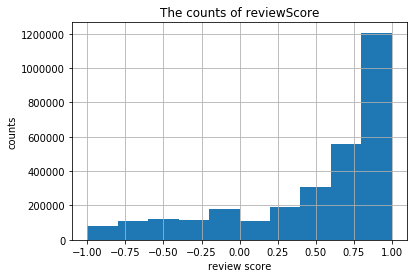

In [49]:
df_product_review["reviewScore"].hist(bins=10)
plt.xlabel("review score")
plt.ylabel("counts")
plt.title("The counts of reviewScore")
plt.show()

In [48]:
pos_num = len(df_product_review[df_product_review["reviewScore"]>=0.05])
neu_num = len(df_product_review[(df_product_review["reviewScore"]>-0.05) & (df_product_review["reviewScore"]<0.05)])
neg_num = len(df_product_review[df_product_review["reviewScore"]<=-0.05])
total_num = len(df_product_review)

print("The number of positive reviews is :{pn} and occupies {p:.3f}% in the review".format(pn=pos_num,p=pos_num/total_num))
print("The number of neutral reviews is :{nu} and occupies {p:.3f}% in the review".format(nu=neu_num,p=neu_num/total_num))
print("The number of negative reviews is :{nu}and occupies {p:.3f}% in the review".format(nu=neg_num,p=neg_num/total_num))

The number of positive reviews is :2353432 and occupies 0.792% in the review
The number of neutral reviews is :124861 and occupies 0.042% in the review
The number of negative reviews is :494893and occupies 0.166% in the review


In [51]:
df_product_review.loc[df_product_review["reviewScore"]>=0.05,"label"]="positive"
df_product_review.loc[(df_product_review["reviewScore"]>-0.05) & (df_product_review["reviewScore"]<0.05),"label"]="neutral"
df_product_review.loc[df_product_review["reviewScore"]<=-0.05,"label"]="negative"

In [53]:
df_product_review.head()

,asin,title,reviewText,ReviewTime,categories,reviewScore,overall,reviewScoreNorm,label
0,0077614992,Principles of Mgmt + Oper-CSUF Custom C,This book was a requirement for a college clas...,2013-02-15,[[Health & Personal Care]],0.2263,5,3.4526,positive
1,0615208479,Brain Fitness Exercises Software,This is a great gift for anyone who wants to h...,2008-12-01,"[[Health & Personal Care, Personal Care]]",0.9748,5,4.9496,positive
2,0615269990,Occam's Razor,Very helpful in learning about different disea...,2014-04-06,"[[Health & Personal Care, Personal Care, Shavi...",0.8313,5,4.6626,positive
3,0615269990,Occam's Razor,Occam's Razor is an unbelievably intuitive and...,2013-12-04,"[[Health & Personal Care, Personal Care, Shavi...",0.9984,5,4.9968,positive
4,0615269990,Occam's Razor,I met the guys from Nerdcore at a medical conf...,2014-04-24,"[[Health & Personal Care, Personal Care, Shavi...",0.4664,2,3.9328,positive


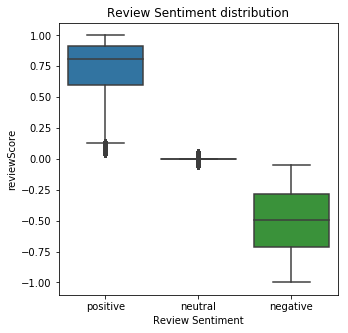

In [57]:
plt.figure(figsize=(5,5))
sns.boxplot(x="label", y="reviewScore", data=df_product_review,order=["positive", "neutral","negative"])
plt.xlabel("Review Sentiment")
plt.title("Review Sentiment distribution")
plt.show()